In [1]:
from functools import partial
import itertools
import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
import jax.numpy as jnp
from jax_tqdm import scan_tqdm

from gauge_field_utils import coef_to_lie_group, wilson_action, mean_wilson_rectangle
from integrators import int_LF2, int_MN2_omelyan, int_MN4_takaishi_forcrand

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# avoids big numbers, therefore reduces floating point errors
def accurate_wilson_hamiltonian_error(q0, p0, q1, p1, beta):

    field0 = coef_to_lie_group(q0)
    field1 = coef_to_lie_group(q1)

    def plaquette(field, mu, nu):
        U_mu = field[..., mu, :, :]
        U_nu = field[..., nu, :, :]

        U_mu_shifted = jnp.roll(U_mu, shift=-1, axis=nu)
        U_nu_shifted = jnp.roll(U_nu, shift=-1, axis=mu)

        Re_Tr_Plaquettes = jnp.einsum("...AB,...BC,...CD,...DA->...",
                                    U_mu, U_nu_shifted,
                                    U_mu_shifted.conj().mT,
                                    U_nu.conj().mT).real

        return Re_Tr_Plaquettes
    
    def plaquette_diff(mu, nu):
        return (plaquette(field0, mu, nu) - plaquette(field1, mu, nu)) / 3
    
    local_hamiltonian_energy_diff = beta * sum(plaquette_diff(mu, nu) for mu in range(4) for nu in range(mu+1, 4)) + jnp.sum((p1 - p0) * ((p1 + p0) / 2), axis=[-1, -2])

    return jnp.sum(local_hamiltonian_energy_diff)

def HMC(beta, afn, nfev_approx):
    action_fn = lambda x: afn(coef_to_lie_group(x), beta)
    action_grad_fn = jax.grad(action_fn)
    
    def step_fn(coef, tau, random_key):
        key1, key2 = jax.random.split(random_key, num=2)
        p0 = jax.random.normal(key1, shape=coef.shape, dtype=coef.dtype)

        coef_prop, pt = int_MN2_omelyan(coef, p0, action_grad_fn, tau, nfev_approx)
        dH = accurate_wilson_hamiltonian_error(coef, p0, coef_prop, pt, beta)

        p_acc = jnp.minimum(1, jnp.exp(-dH))

        coef_next = jax.lax.cond(
            jax.random.uniform(key2) < p_acc,
            lambda: coef_prop,
            lambda: coef
        )

        return coef_next, (dH, p_acc)

    return step_fn

def warmup_tint(coef, beta, random_key, observable_fn, tau, iters=2000, nfev_approx=20):
    stepper_fn = jax.jit(HMC(beta, wilson_action, nfev_approx))
    
    @scan_tqdm(iters, print_rate=1, tqdm_type="notebook")
    def warmup_step(carry, step):
        coef, rng_key, running_p_acc = carry
        rng_key, k1 = jax.random.split(rng_key)
        
        coef, (dH, p_acc) = stepper_fn(coef, tau * (0.001 + 0.999*jnp.tanh(step/(10*beta*tau))), k1)
        running_p_acc = (running_p_acc * step + p_acc) / (step + 1)
        o = observable_fn(coef)
        jax.debug.print("warmup step {step} ; o={o} ; dH={dH} ; p_acc={p_acc}", step=step, o=o, dH=dH, p_acc=running_p_acc)

        carry = (coef, rng_key, running_p_acc)
        return carry, o

    (coef, *_), O = jax.lax.scan(
        warmup_step,
        init=(coef, random_key, 0),
        xs=np.arange(iters),
        length=iters
    )

    return coef, O

@partial(jax.jit, static_argnames=["R_range", "T_range"])
def calculate_wilson_loops(gauge_coef, R_range, T_range):
    R_min, R_max = R_range
    T_min, T_max = T_range
    wilson_loop_values = jnp.array([mean_wilson_rectangle(coef_to_lie_group(gauge_coef), R, T, time_unique=False) for R, T in itertools.product(range(R_min, R_max+1), range(T_min, T_max+1))]).reshape(R_max-R_min+1, T_max-T_min+1)
    return wilson_loop_values

In [4]:
L = (16, 8, 8, 8)
R_range = (1, 8)
T_range = (1, 16)

random_key, key1, key2 = jax.random.split(jax.random.key(0), num=3)
coef = jax.random.normal(key1, shape=(*L, 4, 8), dtype=jnp.float32)

In [5]:
coef, O = warmup_tint(
    coef,
    beta=6.7,
    random_key=random_key,
    observable_fn=jax.jit(lambda x: mean_wilson_rectangle(coef_to_lie_group(x), 3, 3, time_unique=False).real),
    tau=1.0,
    iters=10000,
    nfev_approx=8
)

2025-03-08 03:10:28.473920: W external/xla/xla/hlo/transforms/host_offloader.cc:360] Token parameters are not supported for streaming.


warmup step 0 ; o=-0.002073874231427908 ; dH=4.1618943214416504e-05 ; p_acc=0.9999583959579468


Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

warmup step 1 ; o=-0.001845241873525083 ; dH=-0.0002627372741699219 ; p_acc=0.9999791979789734
warmup step 2 ; o=-0.002000054344534874 ; dH=-0.0006728172302246094 ; p_acc=0.9999861717224121
warmup step 3 ; o=-0.002093181014060974 ; dH=-0.003468036651611328 ; p_acc=0.9999896287918091
warmup step 4 ; o=-0.001685712835751474 ; dH=-0.012094497680664062 ; p_acc=0.9999917149543762
warmup step 5 ; o=-0.0008899857639335096 ; dH=-0.029458999633789062 ; p_acc=0.999993085861206
warmup step 6 ; o=-0.002022432629019022 ; dH=-0.05967903137207031 ; p_acc=0.9999940991401672
warmup step 7 ; o=-0.000823404174298048 ; dH=-0.1092519760131836 ; p_acc=0.9999948143959045
warmup step 8 ; o=-0.0005692786071449518 ; dH=-0.1842021942138672 ; p_acc=0.9999953508377075
warmup step 9 ; o=-0.00176741904579103 ; dH=-0.2708282470703125 ; p_acc=0.9999958276748657
warmup step 10 ; o=-0.0023678159341216087 ; dH=-0.4033088684082031 ; p_acc=0.9999961853027344
warmup step 11 ; o=-0.005810397677123547 ; dH=-0.547149658203125 

In [14]:
wilson_loops = []

stepper_fn = jax.jit(HMC(6.7, wilson_action, nfev_approx=8))

for i in (bar := tqdm(range(20000))):
    random_key, key1 = jax.random.split(random_key)
    coef, (dH, p_acc) = stepper_fn(coef, tau=1.0, random_key=key1)

    # Calculate wilson loops
    wilson_loops.append(calculate_wilson_loops(coef, R_range, T_range))

    bar.set_postfix({"dH": dH})

  0%|          | 0/20000 [00:00<?, ?it/s]

 73%|███████▎  | 14629/20000 [38:24<14:06,  6.35it/s, dH=0.19389343]    


KeyboardInterrupt: 

In [59]:
wilson_loops = jnp.array(wilson_loops)
mean_loops = jnp.real(wilson_loops[200:].mean(axis=0)).copy()
omrt_loops = 1 - mean_loops/3

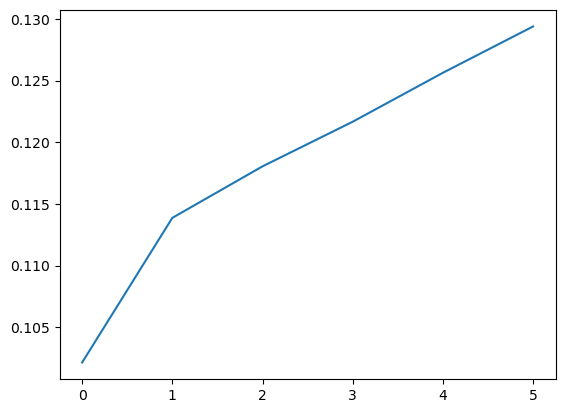

In [60]:
plt.plot(jnp.log(mean_loops[:-2,5] / mean_loops[:-2,6]))
plt.show()

In [61]:
sigma, V0, alpha = jnp.polyfit(
    1+jnp.arange(5+1).astype(jnp.float32),
    jnp.log(mean_loops[:-2,5] / mean_loops[:-2,6]) * (1+jnp.arange(5+1)),
    deg=2
)

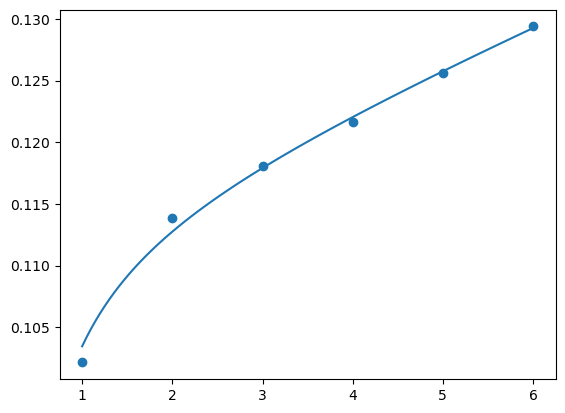

In [62]:
x = 1+jnp.linspace(0, 5, 100)
y = V0 + alpha / x + sigma * x

plt.scatter(1+jnp.arange(5+1), jnp.log(mean_loops[:-2,5] / mean_loops[:-2,6]))
plt.plot(x, y)
plt.show()

In [63]:
jnp.sqrt(sigma) / 440 * 1000 * 0.1973164956590371

Array(0.0249498, dtype=float32)